This notebook builds on mel_model_new_sim to use real data.  Still just for one mass bin.  Could rework this to fit each mass bin in turn.  However, also achievable with more complex code in mel\_model\_bins\_\*, if turn off fitting of inter-bin rates.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import odeint
from astropy import cosmology
from IPython.display import Image
import pickle

In [2]:
# Steven's emcee stuff
from convenience import run_emcee
from pdfs import norm_logpdf, beta_logpdf
import plots

In [3]:
%matplotlib inline
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 12

In [4]:
C = cosmology.FlatLambdaCDM(70.0, 0.3)

In [5]:
states = pd.Index(('BD', 'RD', 'RE'))
nStates = len(states)

In [6]:
rate_labels = [['$r_{' + '{} \\rightarrow {}'.format(s2, s1) + '}$' for s2 in states] for s1 in states]
rate_labels = pd.DataFrame(index='to ' + states, columns='from ' + states, data=rate_labels)
rate_evol_labels = rate_labels.replace('\$r', '$\dot{r}', regex=True)
N_labels = '$N_{' + states + '}$'

In [7]:
N_labels

Index(['$N_{BD}$', '$N_{RD}$', '$N_{RE}$'], dtype='object')

In [8]:
rate_labels

,from BD,from RD,from RE
to BD,$r_{BD \rightarrow BD}$,$r_{RD \rightarrow BD}$,$r_{RE \rightarrow BD}$
to RD,$r_{BD \rightarrow RD}$,$r_{RD \rightarrow RD}$,$r_{RE \rightarrow RD}$
to RE,$r_{BD \rightarrow RE}$,$r_{RD \rightarrow RE}$,$r_{RE \rightarrow RE}$


In [9]:
rate_evol_labels

,from BD,from RD,from RE
to BD,$\dot{r}_{BD \rightarrow BD}$,$\dot{r}_{RD \rightarrow BD}$,$\dot{r}_{RE \rightarrow BD}$
to RD,$\dot{r}_{BD \rightarrow RD}$,$\dot{r}_{RD \rightarrow RD}$,$\dot{r}_{RE \rightarrow RD}$
to RE,$\dot{r}_{BD \rightarrow RE}$,$\dot{r}_{RD \rightarrow RE}$,$\dot{r}_{RE \rightarrow RE}$


Basic differential equations:

$\frac{dN_{BD}}{dt} = - N_{BD} \, (r_{BD \rightarrow RD} + r_{BD \rightarrow RE})$

$\frac{dN_{RD}}{dt} = - N_{RD} \, r_{RD \rightarrow RE} + N_{BD} \, r_{BD \rightarrow RD}$

$\frac{dN_{RE}}{dt} = + N_{BD} \, r_{BD \rightarrow RE} + N_{RD} \, r_{RD \rightarrow RE}$

In [10]:
# Set rates per galaxy in Gyr^{-1} at fiducial redshift
rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((nStates, nStates)))
rates['from BD']['to RD'] = 0.05
rates['from RD']['to RE'] = 0.05
rates['from BD']['to RE'] = 0.01
for s in states:
    rates['from ' + s]['to ' + s] = 0
    rates['from ' + s]['to ' + s] = - rates['from ' + s].sum()
rates

,from BD,from RD,from RE
to BD,-0.06,0.00,0.0
to RD,0.05,-0.05,0.0
to RE,0.01,0.05,-0.0


In [11]:
# Modelling rates as linear function of cosmic time
#(for simplicity, should probably choose someting more appropriate)
rates_evol = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((nStates, nStates)))
rates_evol['from BD']['to RD'] = 0.01  # comment out this to have no evolution!

In [12]:
def rates_function(rates, rates_evol, t, t0):
    rates = rates + rates_evol * (t - t0)
    # * For a closed model the columns of the rates matrix must sum to zero
    #   so there is no creation/destruction of galaxies, this is enforced here.
    # * Creation/destruction of galaxies basically means they move in to or
    #   out of the sample given the selection criteria.
    # * Another possibility is merging, where one galaxies is 'destroyed' in
    #   each merger.
    # * If one wishes to create/destroy galaxies then that could perhaps
    #   be achieved by allowing rates to not sum to zero in each column.
    #   However, the total numbers of galaxies moving between states are
    #   proportional to the number currently in the initial state, which
    #   probably doesn't make much sense for creation.
    #   Alternatively, one could add an additional state(s) representing the pool(s)
    #   from which galaxies are created/destroyed (but this would be evolved itself).
    #   Or one could add additional terms in the differential equation to
    #   describe the creation/destruction of galaxies.
    # * Another issue is multiple selection criteria, e.g. mass bins.
    #   These are essentially different states, and we can model transitions
    #   between them in the same manner: in a small time a galaxy in a given state
    #   will have a particular (potentially time dependent) probability of moving
    #   from one mass bin to the next
    #   (proportional to [SFR + merger accretion rate] / mass_bin_width).
    # * In principle, the rates related to the destruction of galaxies in particular
    #   states due to merging and the mass growth of the merger remnant are related.
    #   In practise this would be pretty complex to manage unless we make some
    #   strict assumptions.  For example, we could assume that only galaxies in the
    #   same state merge (hence ~doubling their mass) and thus require the
    #   destruction rate to be proportional to the mass bin transition rate
    #   (where the factor depends on the width of the mass bin).
    #   If we get too complicated, then it would make more sense to simulate a large
    #   population of individual galaxies rather than consider a small set of states.
    for s in states:
        rates.loc['to ' + s, 'from ' + s] = 0
        rates.loc['to ' + s, 'from ' + s] = - rates['from ' + s].sum()
    return rates

In [13]:
# test it out...
rates_function(rates, rates_evol, t=C.age(0.3).value, t0=C.age(1.0).value)

,from BD,from RD,from RE
to BD,-0.102965,0.00,0.0
to RD,0.092965,-0.05,0.0
to RE,0.010000,0.05,-0.0


In [14]:
def model(N, t, ratefn, rates, rates_evol, t0):
    rates = ratefn(rates, rates_evol, t, t0)
    return np.dot(rates, N)

In [15]:
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle, encoding='latin1')

In [16]:
mdata = results['m_centers'][1:]
zdata = results['z_centers']
tdata = C.age(zdata)
z0 = 1.0
t0 = C.age(z0).value

In [17]:
# select a single mass bin
mass_bin_i = 2

In [18]:
Ndata = pd.DataFrame(index=zdata, columns=N_labels, data=np.zeros((len(zdata), nStates)))
i = mass_bin_i
mresults = results['M={:.2f}'.format(mdata[i-1])]
for key, value in mresults.items():
    if key.startswith('N'):
        state = '{}'.format(key[2:])
        Ndata['$N_{' + state + '}$'] = value
Ndata = Ndata[::-1]
Nerr = np.sqrt(Ndata)
nGal = Ndata.sum(1)
Ndata = (Ndata.T / nGal).T
Nerr = (Nerr.T / nGal).T

In [19]:
Ndata

,$N_{BD}$,$N_{RD}$,$N_{RE}$
0.99,0.627546,0.044692,0.327762
0.76,0.494961,0.054446,0.450594
0.54,0.574155,0.058389,0.367457
0.31,0.525741,0.104524,0.369735


In [20]:
Nerr

,$N_{BD}$,$N_{RD}$,$N_{RE}$
0.99,0.019989,0.005334,0.014446
0.76,0.016325,0.005414,0.015576
0.54,0.026355,0.008405,0.021084
0.31,0.028639,0.012770,0.024017


In [21]:
def calc_F(N, Nerr=None):
    F = pd.DataFrame(index=N.index)
    Ferr = pd.DataFrame(index=N.index)
    F['$f_{R|D}$'] = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{BD}$'])
    F['$f_{D|R}$'] = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{RE}$'])
    if Nerr is not None:
        NDsum = N['$N_{RD}$'] + N['$N_{BD}$']
        dfRDdNRD = 1 / NDsum - N['$N_{RD}$'] / NDsum**2
        dfRDdNBD = - N['$N_{RD}$'] / NDsum**2
        Ferr['$f_{R|D}$'] = np.sqrt(dfRDdNRD**2 * Nerr['$N_{RD}$']**2 + 
                                              dfRDdNBD**2 * Nerr['$N_{BD}$']**2)
        NRsum = N['$N_{RD}$'] + N['$N_{RE}$']
        dfRDdNRD = 1 / NRsum - N['$N_{RD}$'] / NRsum**2
        dfRDdNRE = - N['$N_{RD}$'] / NRsum**2
        Ferr['$f_{D|R}$'] = np.sqrt(dfRDdNRD**2 * Nerr['$N_{RD}$']**2 + 
                                              dfRDdNRE**2 * Nerr['$N_{RE}$']**2)
        return F, Ferr
    else:
        return F

In [22]:
Fdata, Ferr = calc_F(Ndata, Nerr)

In [23]:
Fdata

,$f_{R|D}$,$f_{D|R}$
0.99,0.066482,0.119992
0.76,0.099099,0.107805
0.54,0.092308,0.137112
0.31,0.165842,0.220395


In [24]:
Ferr

,$f_{R|D}$,$f_{D|R}$
0.99,0.007667,0.013435
0.76,0.009354,0.010126
0.54,0.012659,0.018333
0.31,0.018505,0.023774


In [25]:
def plot_N(N, Nerr, Nfit=None):
    fig, ax = plt.subplots(figsize=(6, 5))
    for j, col in enumerate(N):
        ax.errorbar(N.index, N[col], Nerr[col], label=col, color='C{}'.format(j))
        if Nfit is not None:
            ax.plot(N.index, Nfit[col], '--', color='C{}'.format(j))
        ax.set(xlabel='$z$', ylabel='$N(z)/N(z={:.1f})$'.format(z0),
              ylim=(0, 1), title='$\log(M/M_\odot) \sim {}$'.format(mdata[i]))
    ax.legend(loc=1, ncol=3)
    plt.tight_layout()

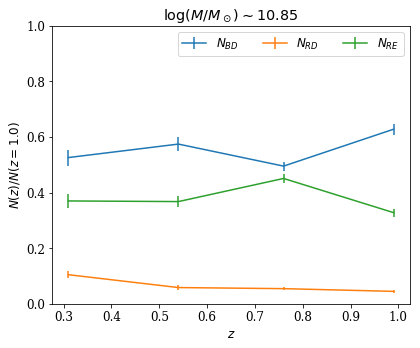

In [26]:
plot_N(Ndata, Nerr)

In [27]:
def plot_F(F, Ferr, Ffit=None):
    fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
    axarr = axarr.flat
    Fm = F.filter(regex=('.*R.D.*'))
    Ferrm = Ferr.filter(regex=('.*R.D.*'))
    if Ffit is not None:
        Ffitm = Ffit.filter(regex=('.*R.D.*'))        
    for j, col in enumerate(Fm):
        axarr[0].errorbar(Fm.index, Fm[col], Ferrm[col], label=col, color='C{}'.format(j))
        if Ffit is not None:
            axarr[0].plot(Ffitm.index, Ffitm[col], '--', color='C{}'.format(j))
    axarr[0].set(xlabel='$z$', ylabel='$f_{R|D}(z)$',
              ylim=(0, 0.4))
    axarr[0].legend(loc=1, ncol=4)
    Fm = F.filter(regex=('.*D.R.*'))
    Ferrm = Ferr.filter(regex=('.*D.R.*'))
    if Ffit is not None:
        Ffitm = Ffit.filter(regex=('.*D.R.*'))        
    for j, col in enumerate(Fm):
        axarr[1].errorbar(Fm.index, Fm[col], Ferrm[col], label=col, color='C{}'.format(j))
        if Ffit is not None:
            axarr[1].plot(Ffitm.index, Ffitm[col], '--', color='C{}'.format(j))
    axarr[1].set(xlabel='$z$', ylabel='$f_{D|R}(z)$',
              ylim=(0, 0.4))
    axarr[1].legend(loc=1, ncol=4)
    plt.tight_layout()

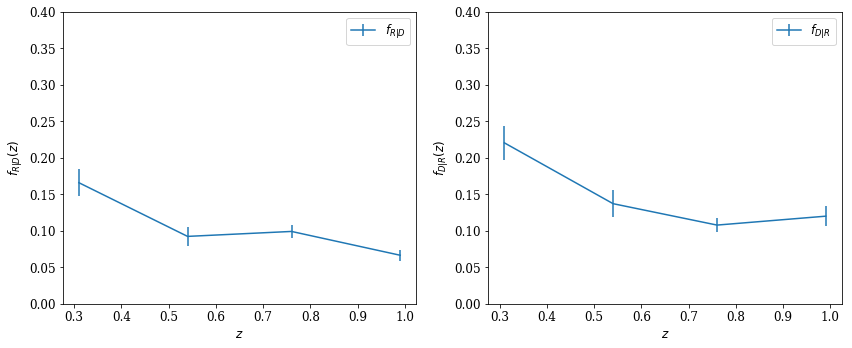

In [28]:
plot_F(Fdata, Ferr)

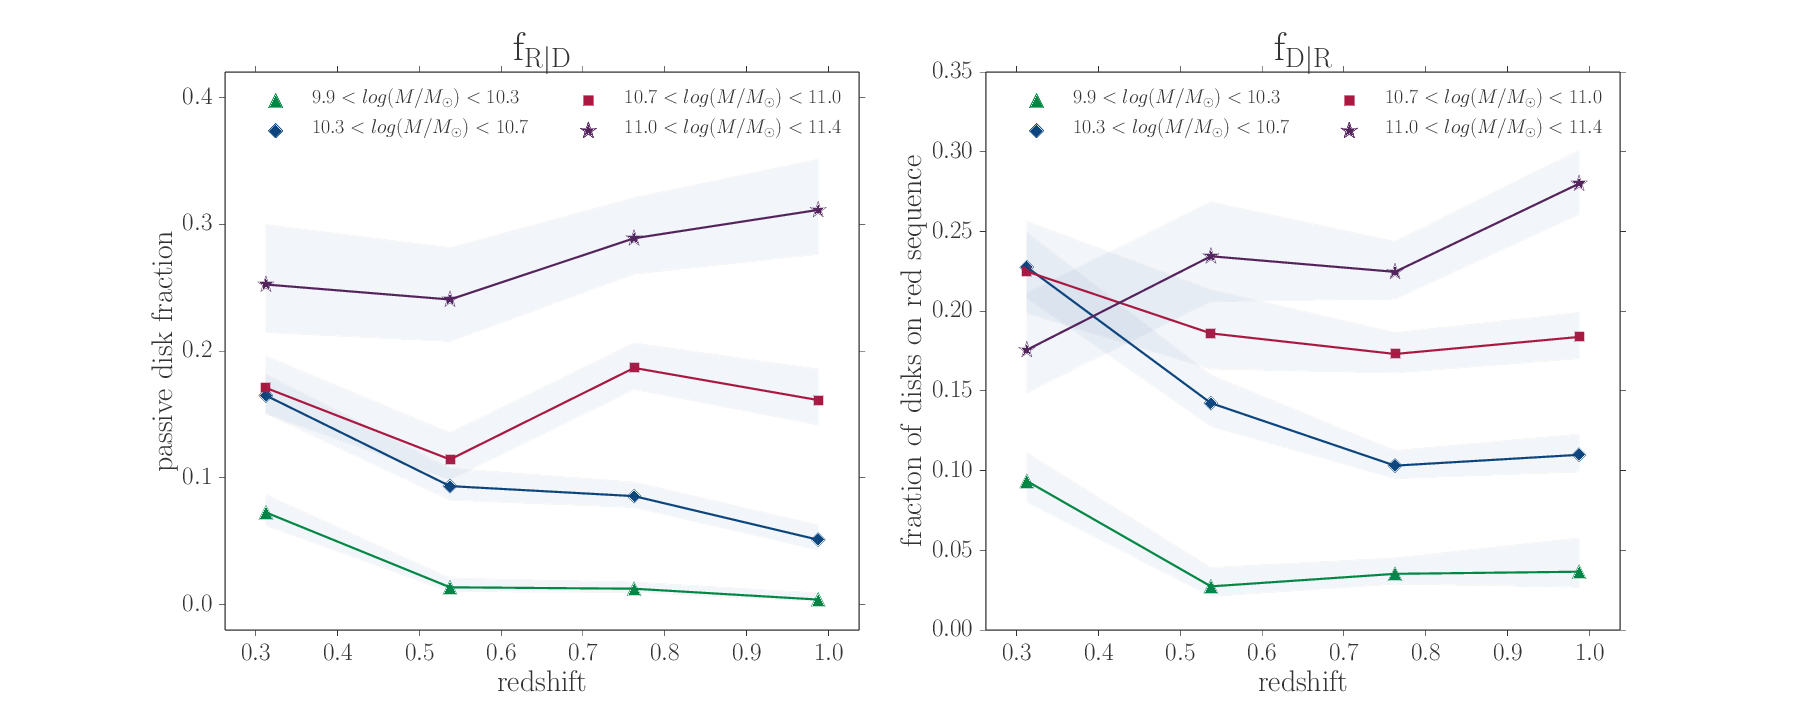

In [29]:
Image('red_disk_fraction.png')

In [30]:
class logProbabilities:
    def __init__(self, fit_N0, fit_rates, fit_rates_evol,
                 Ndata, Nerr, tdata, ratefn, N0_init, rates_init, rates_evol_init,
                 t0, N_labels, rate_labels, rate_evol_labels):
        # a boolean matrix describing which rates and evolutions to fit
        self.fit_N0 = fit_N0.copy()
        self.fit_rates = fit_rates.copy()
        self.fit_rates_evol = fit_rates_evol.copy()
        self.nStates = len(fit_rates)
        self.nFitN0 = self.fit_N0.values.sum()
        self.nFitRates = self.fit_rates.values.sum()
        self.nFitRatesEvol = self.fit_rates_evol.values.sum()
        self.pars = []
        self.pars.extend(N_labels.values[self.fit_N0.values])
        self.pars.extend(rate_labels.values[self.fit_rates.values])
        self.pars.extend(rate_evol_labels.values[self.fit_rates_evol.values])
        self.pars = pd.DataFrame(self.pars, columns=['parameter'])
        self.nPar = self.nFitN0 + self.nFitRates + self.nFitRatesEvol
        # the measured number density, Ndata,
        # in each state at time, tdata,
        # with its error, Nerr
        self.Ndata = Ndata.copy()
        self.Nerr = Nerr.copy()        
        self.tdata = tdata.copy()
        # the current rate matrix is determined using ratefn
        # from N0, the number densities at t0; rates, the rates at t0; and rates_evol
        self.ratefn = ratefn
        self.N0 = N0_init.copy()
        self.rates = rates_init.copy()
        self.rates_evol = rates_evol_init.copy()
        self.t0 = t0

    def split_pars(self, p):
        start, end = (0, self.nFitN0)
        p_N0 = p[start:end]
        start, end = (end, end + self.nFitRates)
        p_rates = p[start:end]
        start, end = (end, end + self.nFitRatesEvol)
        p_rates_evol = p[start:end]
        return p_N0, p_rates, p_rates_evol
        
    def evaluate(self, t, p):
        # update the model quantities given the current parameters
        p_N0, p_rates, p_rates_evol = self.split_pars(p)
        self.N0.values[self.fit_N0.values] = p_N0
        self.rates.values[self.fit_rates.values] = p_rates
        self.rates_evol.values[self.fit_rates_evol.values] = p_rates_evol
        # compute N at each tdata, given current parameters
        N = odeint(model, self.N0, t,
                   args=(self.ratefn, self.rates, self.rates_evol, self.t0))
        return N
    
    def prior(self, inpars):
        inshape = inpars.shape
        inpars = inpars.reshape((-1, self.nPar))
        lnP = np.zeros(inpars.shape[0])
        for i, p in enumerate(inpars):
            p_N0, p_rates, p_rates_evol = self.split_pars(p)
            lnP[i] = stats.uniform(0, 1).logpdf(p_N0).sum()
            lnP[i] += stats.uniform(0, 1).logpdf(p_rates).sum()
            lnP[i] += norm_logpdf(p_rates_evol, 0, 0.1).sum()
        return lnP.reshape(inshape[:-1])
    
    def likelihood(self, inpars):
        inshape = inpars.shape
        inpars = inpars.reshape((-1, self.nPar))
        lnL = np.zeros(inpars.shape[0])
        for i, p in enumerate(inpars):
            N = self.evaluate(self.tdata, p)
            # calculate Likelihood of computed N given Ndata and Nerr
            lnL[i] = norm_logpdf(N, self.Ndata.values, self.Nerr.values).sum()
        return lnL.reshape(inshape[:-1])
    
    def posterior(self, inpars):
        lnL = self.likelihood(inpars)
        lnP = self.prior(inpars)
        return lnL + lnP
    
    def neg_posterior(self, inpars):
        return -self.posterior(inpars)
    
    def init_pars(self, shape):
        ip = np.zeros(shape + (self.nPar,))
        start, end = (0, self.nFitN0)
        ip[..., start:end] = stats.uniform.rvs(0, 1, size=shape + (self.nFitN0,))
        start, end = (end, end + self.nFitRates)
        ip[..., start:end] = stats.uniform.rvs(0, 1, size=shape + (self.nFitRates,))
        start, end = (end, end + self.nFitRatesEvol)
        ip[..., start:end] = stats.norm.rvs(0, 0.1, size=shape + (self.nFitRatesEvol,))
        return ip

In [31]:
fit_N0 = pd.Series(index='$N_{' + states + '}$', data=np.zeros(nStates, np.bool))
fit_rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
                         data=np.zeros((nStates, nStates), np.bool))
fit_rates_evol = pd.DataFrame(index='to ' + states, columns='from ' + states,
                         data=np.zeros((nStates, nStates), np.bool))

# Select which parameters to fit.
fit_N0[:] = True
fit_rates['from BD']['to RD'] = True
fit_rates['from RD']['to RE'] = True
fit_rates['from BD']['to RE'] = True
fit_rates_evol['from BD']['to RD'] = True
fit_rates_evol['from BD']['to RE'] = True
fit_rates_evol['from RD']['to RE'] = True

In [32]:
fit_N0

$N_{BD}$    True
$N_{RD}$    True
$N_{RE}$    True
dtype: bool

In [33]:
fit_rates

,from BD,from RD,from RE
to BD,False,False,False
to RD,True,False,False
to RE,True,True,False


In [34]:
fit_rates_evol

,from BD,from RD,from RE
to BD,False,False,False
to RD,True,False,False
to RE,True,True,False


In [35]:
# Define initial values.
# Those to be fit will vary.
# The rest will be held fixed at their initial values.
N0_init = pd.Series(Ndata.iloc[0], name=False)
rates_init = pd.DataFrame(index='to ' + states, columns='from ' + states,
                          data=np.zeros((nStates, nStates)))
rates_evol_init = pd.DataFrame(index='to ' + states, columns='from ' + states,
                               data=np.zeros((nStates, nStates)))

In [36]:
N0_init

$N_{BD}$    0.627546
$N_{RD}$    0.044692
$N_{RE}$    0.327762
dtype: float64

In [37]:
rates_init

,from BD,from RD,from RE
to BD,0.0,0.0,0.0
to RD,0.0,0.0,0.0
to RE,0.0,0.0,0.0


In [38]:
rates_evol_init

,from BD,from RD,from RE
to BD,0.0,0.0,0.0
to RD,0.0,0.0,0.0
to RE,0.0,0.0,0.0


In [39]:
logProb = logProbabilities(fit_N0, fit_rates, fit_rates_evol, Ndata, Nerr, tdata,
                           rates_function, N0_init, rates_init, rates_evol_init,
                           t0, N_labels, rate_labels, rate_evol_labels)

In [40]:
logProb.pars

,parameter
0,$N_{BD}$
1,$N_{RD}$
2,$N_{RE}$
3,$r_{BD \rightarrow RD}$
4,$r_{BD \rightarrow RE}$
5,$r_{RD \rightarrow RE}$
6,$\dot{r}_{BD \rightarrow RD}$
7,$\dot{r}_{BD \rightarrow RE}$
8,$\dot{r}_{RD \rightarrow RE}$


In [41]:
logProb.posterior(logProb.init_pars((5,)))

array([ -1992952.16997312, -42970873.5821494 , -32415258.748826  ,
        -1349051.3957313 ,  -3732846.12623004])

In [42]:
start = [0.5, 0.1, 0.4, 0.05, 0.01, 0.01, 0.0, 0.0, 0.0]

In [43]:
result = scipy.optimize.minimize(logProb.neg_posterior, start, tol=1e-2)
result

/home/ppzsb1/software/anaconda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/ppzsb1/software/anaconda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/ppzsb1/software/anaconda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/ppzsb1/software/anaconda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/ppzsb1/software/anaconda/envs/py3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_sc

      fun: -26.249372363718244
 hess_inv: array([[  2.31420097e-04,  -3.13822110e-06,  -8.53884754e-05,
         -4.99684864e-05,   1.37394216e-04,  -1.82283358e-04,
          2.07973618e-05,  -8.83525109e-05,   1.10363069e-04],
       [ -3.13822110e-06,   2.34747521e-05,  -7.82732630e-06,
         -4.13055443e-05,   1.31371395e-05,  -8.22751059e-05,
          2.11036194e-05,  -7.14499916e-06,   1.88522735e-05],
       [ -8.53884754e-05,  -7.82732630e-06,   1.75314957e-04,
         -1.47467642e-05,  -5.75413094e-05,  -1.96415222e-04,
         -6.49782365e-06,   6.12414126e-05,   7.55298023e-06],
       [ -4.99684864e-05,  -4.13055443e-05,  -1.47467642e-05,
          7.96045928e-04,  -6.74789492e-04,   3.71731956e-03,
         -2.41260391e-04,   1.57414161e-04,  -8.86119484e-04],
       [  1.37394216e-04,   1.31371395e-05,  -5.75413094e-05,
         -6.74789492e-04,   1.76421827e-03,  -4.24902297e-03,
          1.84393298e-04,  -5.80399668e-04,   1.02254209e-03],
       [ -1.82283358e-0

In [44]:
Nfit = Ndata.copy()
Nfit[:] = logProb.evaluate(tdata, result.x)

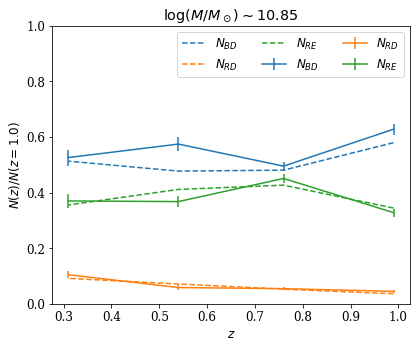

In [45]:
plot_N(Ndata, Nerr, Nfit)

In [46]:
Ffit = calc_F(Nfit)

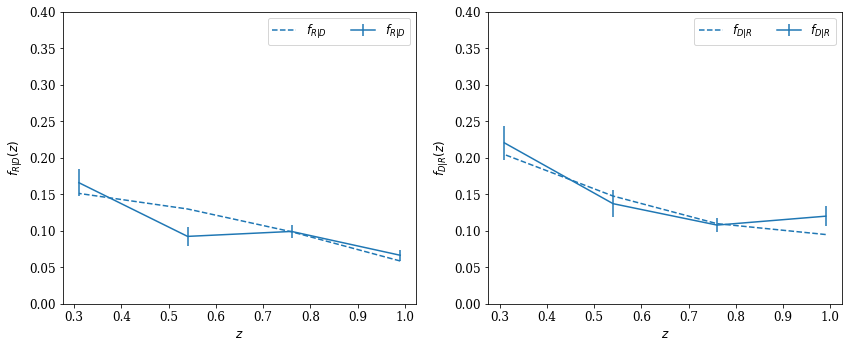

In [ ]:
plot_F(Fdata, Ferr, Ffit)

In [ ]:
sampler = run_emcee(logProb.likelihood, logProb.prior, logProb.init_pars,
                    ntemps=3, nwalkers=50, nsamples=1500,
                    minlogbeta=None, nupdates=100, threads=4,
                    outfilename='mel_data', saveall=True)

Steps: 15 30 45 60

In [ ]:
statistics = plots.print_emcee(sampler, logProb.pars['parameter'], nburn=750,
                          model=logProb.evaluate, x=tdata, y=Ndata, yerror=Nerr,
                          truths=truth, outfilename='mel_data')